<a href="https://colab.research.google.com/github/teddyk251/detecto/blob/master/detecto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecto Demo

Thanks for checking out [Detecto](https://github.com/alankbi/detecto)! To work alongside this tutorial, follow the following steps:

*   Create a new Drive folder
*   Copy this Colab notebook into your folder
*   Download the demo dataset [here](https://github.com/alankbi/detecto/blob/master/docs/_static/dog_dataset.zip) (*) and upload the unzipped contents to your folder

Make sure your notebook has the GPU enabled: Edit -> Notebook settings

In our dataset, we have about 300 labeled images of Chihuahuas and Golden Retrievers. We'll train an object detection model to distinguish between the two. 

** This dataset is a modified subset of the [Stanford Dogs Dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/).* 

First, mount your drive to give the notebook access to your Drive.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Next, change directory to wherever you created your folder. 

In [0]:
import os

# TODO: Change this to your Drive folder location
WORKING_DIRECTORY = '/content/drive/My Drive/Detecto/Demo'

os.chdir(WORKING_DIRECTORY)

In [0]:
# List the contents of your working directory
# It should contain at least three folders: images, train_labels, and val_labels
!ls

detecto.ipynb  images  train_labels  val_labels


Now, let's install the Detecto package using pip. 

In [0]:
# Note: if it states you must restart the runtime in order to use a
# newly installed version of a package, you do NOT need to do this. 
!pip install detecto

Import everything we need in the following code block:

In [0]:
import torch
import torchvision
import matplotlib.pyplot as plt

from torchvision import transforms
from detecto import core, utils, visualize

To check that everything's working, we can try reading in one of the images from our images folder. 

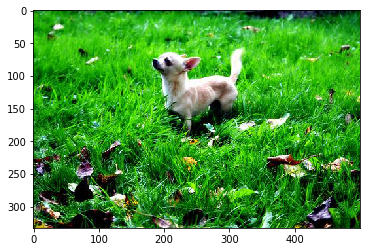

In [0]:
image = utils.read_image('images/n02085620_275.jpg')
plt.imshow(image)
plt.show()

How cute! Now, we're ready to create our dataset and train our model. However, before doing so, it's a bit slow working with hundreds of individual XML label files, so we should convert them into a single CSV file to save time later down the line. 

In [0]:
# Do this twice: once for our training labels and once for our validation labels
utils.xml_to_csv('train_labels', 'train.csv')
utils.xml_to_csv('val_labels', 'val.csv')

,filename,width,height,class,xmin,ymin,xmax,ymax
0,n02099601_10.jpg,500,334,golden_retriever,24,7,499,329
1,n02099601_3414.jpg,400,329,golden_retriever,41,26,375,305
2,n02099601_5893.jpg,500,375,golden_retriever,138,94,353,314
3,n02085620_3093.jpg,375,500,Chihuahua,155,183,320,427
4,n02085620_3928.jpg,500,375,Chihuahua,75,21,399,374
...,...,...,...,...,...,...,...,...
75,n02099601_5240.jpg,500,456,golden_retriever,60,167,477,442
76,n02085620_1271.jpg,360,351,Chihuahua,19,3,324,350
77,n02085620_2208.jpg,500,375,Chihuahua,178,144,231,249
78,n02099601_7119.jpg,500,375,golden_retriever,257,61,454,336


Below, we create our dataset, applying a couple of transforms beforehand. These are optional, but they can be useful for augmenting your dataset without gathering more data. 

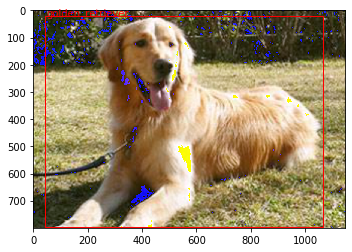

In [0]:
# Specify a list of transformations for our dataset to apply on our images
transform_img = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(800),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    utils.normalize_transform(),
])

dataset = core.Dataset('train.csv', 'images/', transform=transform_img)

# dataset[i] returns a tuple containing our transformed image and
# and a dictionary containing label and box data
image, target = dataset[0]

# Show our image along with the box. Note: it may
# be colored oddly due to being normalized by the 
# dataset and then reverse-normalized for plotting
visualize.show_labeled_image(image, target['boxes'], target['labels'])

Finally, let's train our model! First, we create a DataLoader over our dataset to specify how we feed the images into our model. We also use our validation dataset to track the accuracy of the model throughout training. 

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:03<00:00, 51.3MB/s]


Epoch 1 of 10
Loss: 0.178065935196355
Epoch 2 of 10
Loss: 0.1505881542339921
Epoch 3 of 10
Loss: 0.11017179023474455
Epoch 4 of 10
Loss: 0.08896893740165979
Epoch 5 of 10
Loss: 0.08508185513783247
Epoch 6 of 10
Loss: 0.08110510329715907
Epoch 7 of 10
Loss: 0.08215797778684646
Epoch 8 of 10
Loss: 0.07870461291167885
Epoch 9 of 10
Loss: 0.07833167728967964
Epoch 10 of 10
Loss: 0.08112786181736738


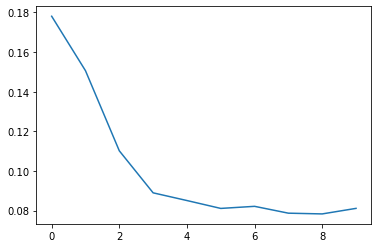

In [0]:
# Create our validation dataset
val_dataset = core.Dataset('val.csv', 'images/')

# Create the loader for our training dataset
loader = core.DataLoader(dataset, batch_size=2, shuffle=True)

# Create our model, passing in all unique classes we're predicting
# Note: make sure these match exactly with the labels in the XML/CSV files!
model = core.Model(['Chihuahua', 'golden_retriever'])

# Train the model! This step can take a while, so make sure you
# the GPU is turned on in Edit -> Notebook settings
losses = model.fit(loader, val_dataset, epochs=10, verbose=True)

# Plot the accuracy over time
plt.plot(losses)
plt.show()

Let's see how well our model does on a couple images from our validation set:

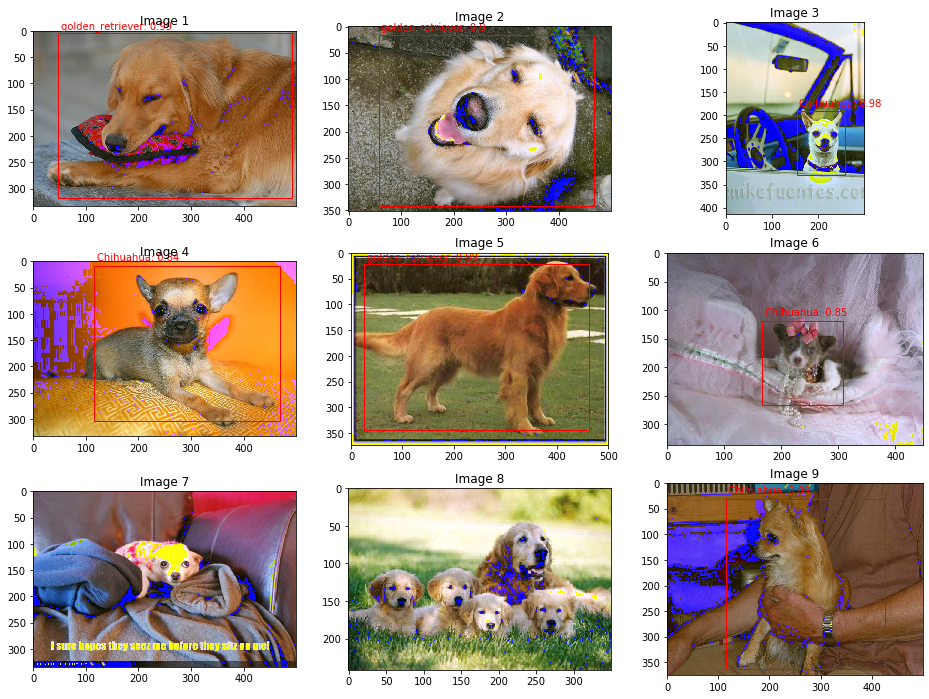

In [0]:
images = []
# Create a list of images 0, 5, 10, ... 40 from val_dataset
for i in range(0, 45, 5):
    image, _ = val_dataset[i]
    images.append(image)

# Plot a 3x3 grid of the model's predictions on our 9 images
visualize.plot_prediction_grid(model, images, dim=(3, 3), figsize=(16, 12))

Overall, the model works as expected; in most of the images, it outputs high confidence values for the correct breed of dog shown. With a bit more fine-tuning, we could make it even better!

## Conclusion

Thanks for making it this far through the demo!

This is as far as the demo goes, but a great next step would be seeing how well the model works on a live video of Chihuahuas and Golden Retrievers in the same frame at the same time. To learn more about Detecto, be sure to check out the [Quickstart guide](https://detecto.readthedocs.io/en/latest/usage/quickstart.html), [Further Usage guide](https://detecto.readthedocs.io/en/latest/usage/further-usage.html), and [API docs](https://detecto.readthedocs.io/en/latest/api.html)!